# Momentum Trend Following Strategy 

In [1]:
"""
Created on Tue Jun 19 22:58:39 2018

@author: Claudio
"""

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import seaborn as sns; sns.set()

Start Dates and Tickers of Index (In this case we used the Chilean Index IPSA)

In [2]:
#start date
yearS=2016
monthS=6
dayS=1

#end date
yearE=2018
monthE=6
dayE=28

#stock ticker
tickers = pd.read_csv('ipsa_tickers.csv')
tickers = tickers.drop(tickers.index[[11,16]])
tickers = tickers.reset_index(drop=True)
#tickers and names of stocks
ticker = tickers.Symbol
names = tickers['Company Name']

Download the 28 stocks from the Index and combine them into a DataFrame of their Adjusted Closing Prices

In [4]:
stocks2 = []

#grab all 28 stocks from IPSA and combine them to one dataframe of 
#adjusted prices
for i in range(0,len(ticker)):
    stocks = pdr.get_data_yahoo(ticker[i], 
                          start=datetime.datetime(yearS,monthS,dayS), 
                          end=datetime.datetime(yearE, monthE, dayE))
    stocks = stocks[['Adj Close']]
    stocks2.append(stocks)
    stocks2[i].rename(columns={'Adj Close':'%s' % (names[i])}, inplace=True)

stocksadjusted = pd.concat(stocks2,axis=1)

Calculate the Moving Averages in order to set the momentum strategy

In [5]:
## Calculate the moving average 
MA50s = []
MA200s = []
for i in range(0,len(ticker)):
    MA50s.append(stocksadjusted[names[i]].rolling(window=50).mean())
    MA200s.append(stocksadjusted[names[i]].rolling(window=200).mean())

moving50final = pd.concat(MA50s,axis=1)
moving200final = pd.concat(MA200s,axis=1)

Initialize the Trading Strategy, Output tells the investor which stocks they should buy according to the strategy

In [6]:
#this strategy is a momentum strategy following market trends
#the if statement is the buying requirements for a stock
#this strategy works for bull markets and its a simple growth analysis

#this output will tell you which stocks you should buy from the list of stocks
corrtickers = []
for i in range(0,len(ticker)):
    if (moving50final.iloc[-1,i] > moving200final.iloc[-1,i]) & (stocksadjusted.iloc[-1,i] > moving50final.iloc[-1,i]):
        print('Buy share of %s' % (names[i]))
        print('Moving Average DIF',moving50final.iloc[-1,i]-moving200final.iloc[-1,i])
        print('Current Dif vs MA',stocksadjusted.iloc[-1,i]-moving50final.iloc[-1,i])
        print('------------------------------------------')
        corrtickers.append(names[i])

Buy share of Banco Santander-Chile
Moving Average DIF 3.37753128051758
Current Dif vs MA 0.1404006958007784
------------------------------------------
Buy share of S.A.C.I. Falabella
Moving Average DIF 19.940407714843786
Current Dif vs MA 8.340527343750182
------------------------------------------
Buy share of Empresas Copec S.A.
Moving Average DIF 487.428820800782
Current Dif vs MA 108.14013671875
------------------------------------------


Correlation Matrix of Selected Stocks

                       Banco Santander-Chile  S.A.C.I. Falabella  \
Banco Santander-Chile               1.000000            0.917022   
S.A.C.I. Falabella                  0.917022            1.000000   
Empresas Copec S.A.                 0.969394            0.903451   

                       Empresas Copec S.A.  
Banco Santander-Chile             0.969394  
S.A.C.I. Falabella                0.903451  
Empresas Copec S.A.               1.000000  


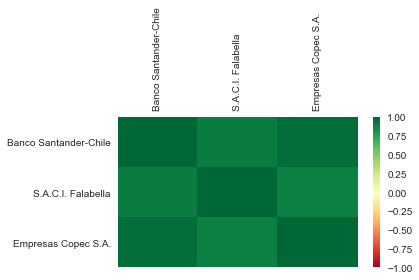

In [7]:
#Now we will see the correlation between the stocks that the model chose
#We want to buy the stocks that their correlation is closer to 0 just so
#if theres any downfall in the market we wanna mimize our loss for our
#portfolio
        
df = stocksadjusted[corrtickers]

#Now we plot the correlation between the stocks
def visualize_data():
    df_corr = df.corr()
    print(df_corr.head())
    #takes only data (numbers) inside the corr matrix
    data =  df_corr.values
    fig = plt.figure()
    #1 by 1 in plot number one
    ax = fig.add_subplot(1,1,1)
    #customizing the plot showing the correlation in color
    #if theres negative correlation if stock goes up other goes down
    heatmap = ax.pcolor(data,cmap = plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0])+0.5,minor = False)
    ax.set_yticks(np.arange(data.shape[1])+0.5,minor = False)
    #errases any gaps from the graph
    ax.invert_yaxis()
    #moves ticks from xaxis to the top
    ax.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    #limit of the color limit of the heatmap of correlationmatrix
    heatmap.set_clim(-1,1)
    plt.tight_layout()
    plt.show()

visualize_data()

Visualization of selected stocks (returns, adjusted prices and moving average graphs). At the time the model was selected BCI and Conchatoro were the two best stocks from the set.

In [8]:
#At the moment this model was created the best option was to buy 
#BCI (18) and ConchaTORO (22) so the next part shows the graphs and when to sell
#the stocks
#N = 18 = BCI, N = 22 = CONCHATORO
N = 18

boughtstock = stocksadjusted[names[N]]
boughtMA50 = moving50final[names[N]]
boughtMA200 = moving200final[names[N]]

stock = boughtstock


## Sample and Filtering data
sample = stock.sample(20)
monthly_sample = stock.resample('M').apply(lambda x: x[-1])
monthly_sample.pct_change()
# Resample `stock` to business months, take last observation as value 
monthlyBM = stock.resample('BM').apply(lambda x: x[-1])
monthlyBM.pct_change()
# Resample `aapl` to quarters, take the mean as value per quarter
quarter = stock.resample("4M").mean()
# Calculate the quarterly percentage change
quarter.pct_change()

Date
2016-06-30         NaN
2016-10-31    0.091484
2017-02-28    0.127670
2017-06-30    0.130665
2017-10-31    0.085288
2018-02-28    0.061674
2018-06-30    0.076387
Name: Banco de Crédito e Inversiones, dtype: float64

Graph of Returns from Selected Stock

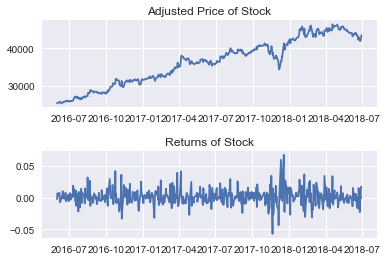

In [10]:
## Returns for Stock
# Assign `Adj Close` to `daily_close`
daily_close = boughtstock
# Daily returns
daily_pct_c = daily_close.pct_change()
# Replace NA values with 0
daily_pct_c.fillna(0, inplace=True)
# Daily log returns
daily_log_returns = np.log(daily_close.pct_change()+1)
daily_log_returns.fillna(0, inplace=True)
# Daily returns not log returns
daily_pct_c = daily_close / daily_close.shift(1) - 1
# Calculate the cumulative daily returns# Calcul 
cum_daily_return = (1 + daily_pct_c).cumprod()
# Resample the cumulative daily return to cumulative monthly return 
cum_monthly_return = cum_daily_return.resample("M").mean()

## Plot and Histogram of daily returns
#linear plot of daily returns
# Just a figure and one subplot
plt.figure(1)
plt.subplot(211)
plt.plot(stock)
plt.title("Adjusted Price of Stock")
plt.subplot(212)
plt.plot(daily_pct_c)
plt.title("Returns of Stock")
plt.subplots_adjust(hspace=.5)

Moving Average Graphs

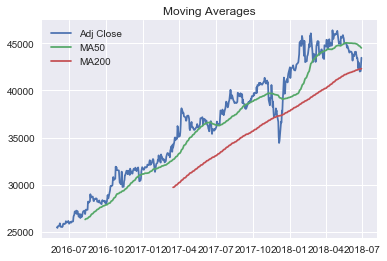

In [12]:
## Moving windows (Moving Average)
# Plot the adjusted closing price, the short and long windows of rolling means
graphMA = pd.concat([boughtstock,boughtMA50,boughtMA200],axis=1)
plt.figure(2)
plt.plot(graphMA)
plt.title("Moving Averages")
plt.legend(['Adj Close','MA50','MA200'])
plt.show()

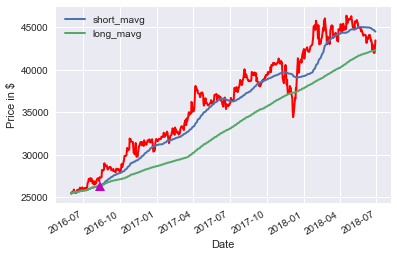

In [13]:
## Signals (Initialize the short and long windows)
short_window = 50
long_window = 200
# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=stock.index)
signals['signal'] = 0.0
# Create short simple moving average over the short window
signals['short_mavg'] = stock.rolling(window=short_window, min_periods=1, center=False).mean()
# Create long simple moving average over the long window
signals['long_mavg'] = stock.rolling(window=long_window, min_periods=1, center=False).mean()
# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   
# Generate trading orders
signals['positions'] = signals['signal'].diff()
# Initialize the plot figure
fig = plt.figure(4)
# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='Price in $')
# Plot the closing price
stock.plot(ax=ax1, color='r', lw=2.)
# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)
# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='m')        
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k')

Volatility Graph

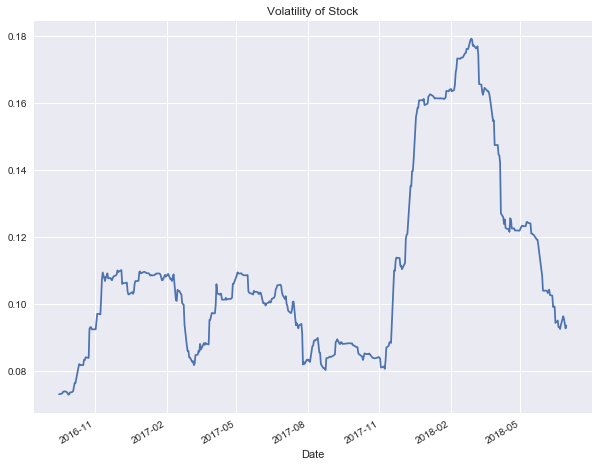

In [14]:
## Volatility Calculation
# Define the minumum of periods to consider 
min_periods = 75 
# Calculate the volatility
vol = daily_pct_c.rolling(min_periods).std() * np.sqrt(min_periods) 
# Plot the volatility
plt.figure(3)
vol.plot(figsize=(10, 8))
# Show the plot
plt.title("Volatility of Stock")
plt.show() 


Sell Strategy (If any of these conditions apply, investor should sell the selected stock)

In [15]:
## Here we see if from momentum strategies we should sell the stocks
## we bought
# 18-bci = 42000 ; 22-conchatoro = 1280
EntryPrice = 42000

if stock[-1] < 0.85*EntryPrice:
    print('Sell that stock')
if boughtMA50[-1] < boughtMA200[-1]:
    print('Sell that stock')
if stock[-1] >= 3*EntryPrice:
    print('Sell that stock')
else:
    print('Maintain Position')

Maintain Position
